# Steering Faithfulness Sandbox

Testing out functions, playing around with code. Sometimes plotting results, too.

In [1]:
import pickle
import matplotlib.pyplot as plt
import json
import re

In [3]:
hint_filtered = []

# Go through results with normal and hinted prompting
# Collect all questions where the presence of the hint changes the model answer from incorrect to correct
for dataset in ['gsm8k', 'MATH-500', 'AIME2024', 'gpqa', 'AIME2025']:
    with open(f"../src/normal_results/{dataset}/deepseek-llama3-8b/1_runs.json", "r") as f:
        normal_results = json.load(f)

    with open(f"../src/hint_results/{dataset}/deepseek-llama3-8b/1_runs.json", "r") as f:
        hint_results = json.load(f)

    incor_to_cor = []
    normal_recs = normal_results['runs'][0]['records']
    hint_recs = hint_results['runs'][0]['records']
    reasoning_length = 15000

    # Filtering for reasoning length to ensure we don't just include questions where the model never completed its answer
    for index, question in enumerate(normal_recs):
        if not question['correct'] and hint_recs[index]['correct'] and question['reasoning_length'] < reasoning_length and str(question['prediction']).split("\\%")[0] != question['gold']:
            incor_to_cor.append(index)

    for index in incor_to_cor:
        hint_filtered.append(hint_recs[index])

In [8]:
alphas = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
acc_results = {}
dataset = 'orig_ds'

for alpha in alphas:
    # for layer in [10, 12, 14, 16, 18, 20, 22, 24, 26, 28]:
    # if alpha == 0.0 and layer in [10, 12, 14, 16, 20, 22, 24, 26, 28]:
    # if alpha == 0.0:
        # acc_results[f"{alpha}_{layer}"] = [0.32075471698113206, 53]
        # continue
    with open(f'../results/steered_gens/deepseek-llama3-8b/{dataset}/{alpha}_gen_all_layer.json', 'rb') as file:
        steered_ans = json.load(file)
    
    answered = 0
    correct = 0
    
    for index, question in enumerate(hint_filtered):
        match = re.search(r'\\boxed{([^}]*)}', steered_ans[index]['response'])
        if not match:
            continue
        else:
            answered += 1
            if match.group(1) == hint_filtered[index]['gold']:
                correct += 1
    
    accuracy = correct / answered
    acc_results[f"{alpha}"] = [accuracy, answered]

# acc_results['0.0'] = [0.32075471698113206, 53]
# acc_results['0.0'] = [0.925531914893617, 94]

In [9]:
acc_results

{'0.0': [0.2765957446808511, 47],
 '0.05': [0.2553191489361702, 47],
 '0.1': [0.2765957446808511, 47],
 '0.15': [0.2708333333333333, 48],
 '0.2': [0.2, 40],
 '0.25': [0.2727272727272727, 44],
 '0.3': [0.29411764705882354, 51],
 '0.35': [0.25, 48],
 '0.4': [0.20408163265306123, 49],
 '0.45': [0.21739130434782608, 46],
 '0.5': [0.18604651162790697, 43],
 '0.55': [0.20454545454545456, 44],
 '0.6': [0.15384615384615385, 39],
 '0.65': [0.2682926829268293, 41],
 '0.7': [0.23255813953488372, 43],
 '0.75': [0.23809523809523808, 42],
 '0.8': [0.23809523809523808, 42],
 '0.85': [0.2, 40],
 '0.9': [0.20454545454545456, 44],
 '0.95': [0.17647058823529413, 34],
 '1.0': [0.21428571428571427, 42]}

In [10]:
# Load in steering result dictionary
with open('../results/data/deepseek-llama3-8b/steering_results_all_layer_orig_ds.pkl', 'rb') as file:
    steering_results = pickle.load(file)

In [16]:
# steering_results['0.0_gen_all_layer'] = 0.6170212765957447
# steering_results['0.0_gen_all_layer'] = 0.5087719298245614 # openr1-math

In [11]:
steering_results

{'0.55_gen_all_layer': 0.4819277108433735,
 '0.35_gen_all_layer': 0.46987951807228917,
 '0.75_gen_all_layer': 0.43373493975903615,
 '0.95_gen_all_layer': 0.42168674698795183,
 '0.7_gen_all_layer': 0.42168674698795183,
 '0.8_gen_all_layer': 0.42168674698795183,
 '0.3_gen_all_layer': 0.4578313253012048,
 '1.0_gen_all_layer': 0.4457831325301205,
 '0.15_gen_all_layer': 0.40963855421686746,
 '0.9_gen_all_layer': 0.43373493975903615,
 '0.45_gen_all_layer': 0.5301204819277109,
 '0.2_gen_all_layer': 0.40963855421686746,
 '0.0_gen_all_layer': 0.4939759036144578,
 '0.65_gen_all_layer': 0.4578313253012048,
 '0.5_gen_all_layer': 0.5060240963855421,
 '0.05_gen_all_layer': 0.46987951807228917,
 '0.4_gen_all_layer': 0.43373493975903615,
 '0.6_gen_all_layer': 0.46987951807228917,
 '0.1_gen_all_layer': 0.43373493975903615,
 '0.85_gen_all_layer': 0.4819277108433735,
 '0.25_gen_all_layer': 0.4457831325301205}

/tmp/ipykernel_110/1378662493.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


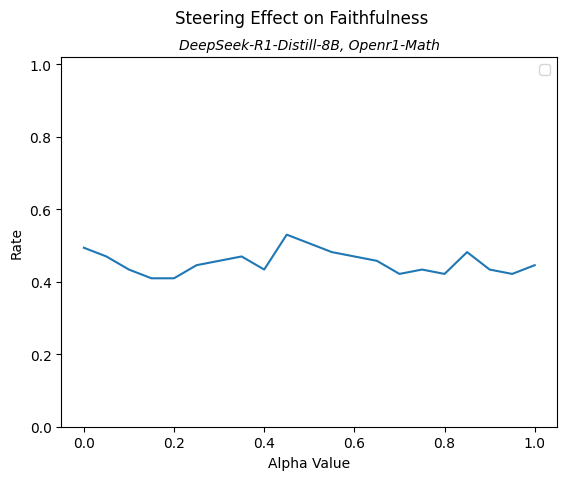

In [12]:
# Generate plot
x = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
y = [steering_results['0.0_gen_all_layer'], steering_results['0.05_gen_all_layer'], steering_results['0.1_gen_all_layer'], \
     steering_results['0.15_gen_all_layer'], steering_results['0.2_gen_all_layer'], steering_results['0.25_gen_all_layer'], \
     steering_results['0.3_gen_all_layer'], steering_results['0.35_gen_all_layer'], steering_results['0.4_gen_all_layer'], \
     steering_results['0.45_gen_all_layer'], steering_results['0.5_gen_all_layer'], steering_results['0.55_gen_all_layer'], \
     steering_results['0.6_gen_all_layer'], steering_results['0.65_gen_all_layer'], steering_results['0.7_gen_all_layer'], \
     steering_results['0.75_gen_all_layer'], steering_results['0.8_gen_all_layer'], steering_results['0.85_gen_all_layer'], \
     steering_results['0.9_gen_all_layer'], steering_results['0.95_gen_all_layer'], steering_results['1.0_gen_all_layer']]
plt.suptitle("Steering Effect on Faithfulness")
plt.title("DeepSeek-R1-Distill-8B, Openr1-Math", fontsize=10, style='italic')
plt.xlabel("Alpha Value")
plt.ylabel("Rate")
plt.ylim(0, 1.02)
plt.plot(x, y, color="C0")
plt.legend();
# plt.savefig("steering_faithfulness_results_openr1.png", dpi=300);

In [27]:
ff_10 = [steering_results['l18_0.0_gen'], steering_results['l10_0.25_gen'], steering_results['l10_0.5_gen'], steering_results['l10_0.75_gen'], steering_results['l10_1.0_gen']]
ff_12 = [steering_results['l18_0.0_gen'], steering_results['l12_0.25_gen'], steering_results['l12_0.5_gen'], steering_results['l12_0.75_gen'], steering_results['l12_1.0_gen']]
ff_14 = [steering_results['l18_0.0_gen'], steering_results['l14_0.25_gen'], steering_results['l14_0.5_gen'], steering_results['l14_0.75_gen'], steering_results['l14_1.0_gen']]
ff_16 = [steering_results['l18_0.0_gen'], steering_results['l16_0.25_gen'], steering_results['l16_0.5_gen'], steering_results['l16_0.75_gen'], steering_results['l16_1.0_gen']]
ff_18 = [steering_results['l18_0.0_gen'], steering_results['l18_0.25_gen'], steering_results['l18_0.5_gen'], steering_results['l18_0.75_gen'], steering_results['l18_1.0_gen']]
ff_20 = [steering_results['l18_0.0_gen'], steering_results['l20_0.25_gen'], steering_results['l20_0.5_gen'], steering_results['l20_0.75_gen'], steering_results['l20_1.0_gen']]
ff_22 = [steering_results['l18_0.0_gen'], steering_results['l22_0.25_gen'], steering_results['l22_0.5_gen'], steering_results['l22_0.75_gen'], steering_results['l22_1.0_gen']]
ff_24 = [steering_results['l18_0.0_gen'], steering_results['l24_0.25_gen'], steering_results['l24_0.5_gen'], steering_results['l24_0.75_gen'], steering_results['l24_1.0_gen']]
ff_26 = [steering_results['l18_0.0_gen'], steering_results['l26_0.25_gen'], steering_results['l26_0.5_gen'], steering_results['l26_0.75_gen'], steering_results['l26_1.0_gen']]
ff_28 = [steering_results['l18_0.0_gen'], steering_results['l28_0.25_gen'], steering_results['l28_0.5_gen'], steering_results['l28_0.75_gen'], steering_results['l28_1.0_gen']]

acc_10 = [acc_results["0.0_18"], acc_results["0.25_10"], acc_results["0.5_10"], acc_results["0.75_10"], acc_results["1.0_10"]]
acc_12 = [acc_results["0.0_18"], acc_results["0.25_12"], acc_results["0.5_12"], acc_results["0.75_12"], acc_results["1.0_12"]]
acc_14 = [acc_results["0.0_18"], acc_results["0.25_14"], acc_results["0.5_14"], acc_results["0.75_14"], acc_results["1.0_14"]]
acc_16 = [acc_results["0.0_18"], acc_results["0.25_16"], acc_results["0.5_16"], acc_results["0.75_16"], acc_results["1.0_16"]]
acc_18 = [acc_results["0.0_18"], acc_results["0.25_18"], acc_results["0.5_18"], acc_results["0.75_18"], acc_results["1.0_18"]]
acc_20 = [acc_results["0.0_18"], acc_results["0.25_20"], acc_results["0.5_20"], acc_results["0.75_20"], acc_results["1.0_20"]]
acc_22 = [acc_results["0.0_18"], acc_results["0.25_22"], acc_results["0.5_22"], acc_results["0.75_22"], acc_results["1.0_22"]]
acc_24 = [acc_results["0.0_18"], acc_results["0.25_24"], acc_results["0.5_24"], acc_results["0.75_24"], acc_results["1.0_24"]]
acc_26 = [acc_results["0.0_18"], acc_results["0.25_26"], acc_results["0.5_26"], acc_results["0.75_26"], acc_results["1.0_26"]]
acc_28 = [acc_results["0.0_18"], acc_results["0.25_28"], acc_results["0.5_28"], acc_results["0.75_28"], acc_results["1.0_28"]]


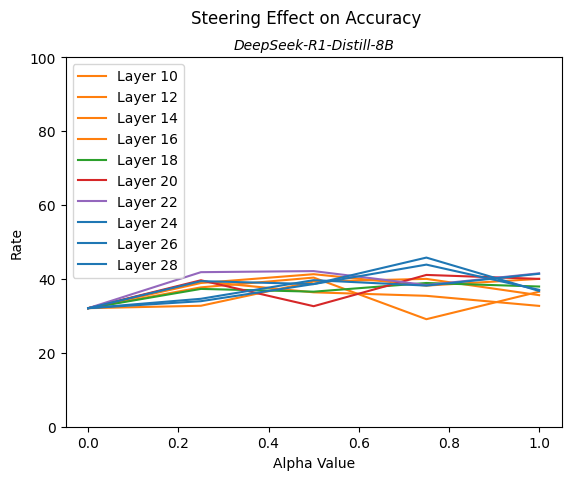

In [28]:
# Generate plot
x = [0.0, 0.25, 0.5, 0.75, 1.0]
plt.suptitle("Steering Effect on Accuracy")
plt.title("DeepSeek-R1-Distill-8B", fontsize=10, style='italic')
plt.xlabel("Alpha Value")
plt.ylabel("Rate")
plt.plot(x, [100 * i[0] for i in acc_10], label="Layer 10", color="C1")
plt.plot(x, [100 * i[0] for i in acc_12], label="Layer 12", color="C1")
plt.plot(x, [100 * i[0] for i in acc_14], label="Layer 14", color="C1")
plt.plot(x, [100 * i[0] for i in acc_16], label="Layer 16", color="C1")
plt.plot(x, [100 * i[0] for i in acc_18], label="Layer 18", color="C2")
plt.plot(x, [100 * i[0] for i in acc_20], label="Layer 20", color="C3")
plt.plot(x, [100 * i[0] for i in acc_22], label="Layer 22", color="C4")
plt.plot(x, [100 * i[0] for i in acc_24], label="Layer 24", color="C0")
plt.plot(x, [100 * i[0] for i in acc_26], label="Layer 26", color="C0")
plt.plot(x, [100 * i[0] for i in acc_28], label="Layer 28", color="C0")
plt.ylim(0, 100)
plt.legend();
# plt.savefig("steering_accuracy_results.png", dpi=300);

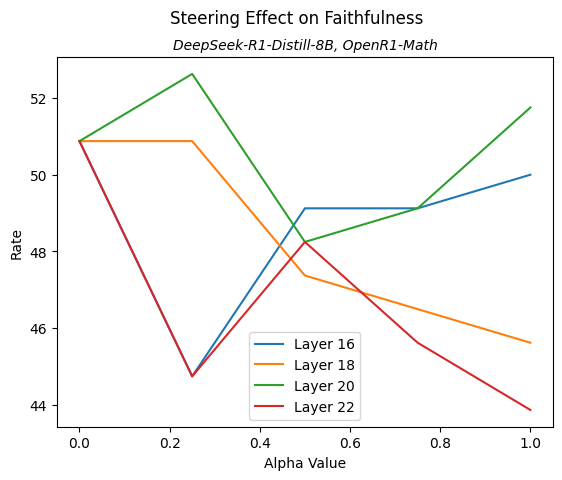

In [30]:
# Generate plot
x = [0.0, 0.25, 0.5, 0.75, 1.0]
plt.suptitle("Steering Effect on Faithfulness")
plt.title("DeepSeek-R1-Distill-8B, OpenR1-Math", fontsize=10, style='italic')
plt.xlabel("Alpha Value")
plt.ylabel("Rate")
# plt.plot(x, [100 * i for i in ff_10], label="Layer 10", color="C0")
# plt.plot(x, [100 * i for i in ff_12], label="Layer 12", color="C1")
# plt.plot(x, [100 * i for i in ff_14], label="Layer 14", color="C2")
plt.plot(x, [100 * i for i in ff_16], label="Layer 16", color="C0")
plt.plot(x, [100 * i for i in ff_18], label="Layer 18", color="C1")
plt.plot(x, [100 * i for i in ff_20], label="Layer 20", color="C2")
plt.plot(x, [100 * i for i in ff_22], label="Layer 22", color="C3")
# plt.plot(x, [100 * i for i in ff_24], label="Layer 24", color="C7")
# plt.plot(x, [100 * i for i in ff_26], label="Layer 26", color="C8")
# plt.plot(x, [100 * i for i in ff_28], label="Layer 28", color="C9")
plt.legend();
plt.savefig("steering_faithfulness_results_openr1.png", dpi=300);

In [14]:
[100 * i for i in ff_20]

[50.877192982456144,
 52.63157894736842,
 48.24561403508772,
 49.122807017543856,
 51.75438596491229]